## Optional analysis of the labels we are left with after the initial filtering pass
Labels are generated in the candidate_label_creation notebook and then filtered in the candidate_filter notebook.

### Pre-requisite steps to run this notebook
1. You need to run the candidate_label_creation and candidate_filter notebooks before this notebook.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utility import run_command

### Parameters
**Required**  
*work_dir*: path to work_dir that was specified in candidate_label_creation and candidate_filter notebooks. This should contain a folder called label_creation and a folder called candidate_filter.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.  
*label_file*: file path for the file that contains wikidata labels.

In [2]:
# **REQUIRED**
work_dir = "../../wikidata_films/profiler_work"
store_dir = "../../wikidata_films"
label_file = "../../wikidata_films/data/labels.en.tsv.gz"

### Process params / set up variables

In [3]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
label_file = os.path.abspath(label_file)

label_creation_dir = "{}/label_creation".format(work_dir)
filter_dir = "{}/candidate_filter".format(work_dir)
    
# Create output directory
output_dir = "{}/analyze_filtered_labels".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = label_creation_dir
os.environ['FILTERED_LABELS'] = filter_dir
os.environ['LABEL_FILE'] = label_file
os.environ["OUT"] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## pre-processing...
To make labels easier to look through, we'll:
1. Add human readable labels* for Wikidata nodes and properties.
2. Add a label-kind column to our labels so that we can key on this after we combine the labels into a single table.
3. Add a column for number of entities of type = label's type
4. Standardize/disambiguate column headers across label kinds so they can be combined into a single table.

*sorry for the ambiguous wording here - "labels" in this sentence refers to a different thing than the labels we are analyzing in this notebook

**AVLs**

In [4]:
if not os.path.isfile("{}/candidate_labels_avl_string_filtered.tsv".format(filter_dir)):
    string_file_exists = False
    print("No string labels file found, skipping this step.")
else:
    string_file_exists = True
    # perform query
    command = "$kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_string_filtered.tsv \
               -i LABEL_FILE -o $OUT/filtered_avl_string_analysis.tsv \
               --graph-cache $STORE \
               --match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `LABEL_FILE`: (type)-[]->(type_lab)' \
               --return 'distinct \"AVL\" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, \"\" as val1_lab, \"\" as val1_ub, \"\" as type2, \"\" as type2_lab, \"\" as prop2, \"\" as prop2_lab, \"\" as val2, \"\" as val2_ub, \"\" as si_units, \"\" as wd_units' \
               --where 'type_lab.kgtk_lqstring_lang_suffix = \"en\"'"
    run_command(command, {"LABEL_FILE" : label_file})

No string labels file found, skipping this step.


In [5]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [6]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RELs**

In [7]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rel_item_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rel_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab), `'"$LABEL_FILE"'`: (val)-[]->(val_lab)' \
--return 'distinct "REL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, val_lab as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND val_lab.kgtk_lqstring_lang_suffix = "en"'

**AILs**

In [8]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, upper_bound:ub, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [9]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, upper_bound:ub, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RAVLs**

In [10]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ravl_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ravl_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, val:val2, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, val2 as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


**RAILs**

In [11]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rail_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rail_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, lb as val2, ub as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


Defining filename variables and the order of columns in our analysis files since we'll need thess in a couple places.

In [12]:
if string_file_exists:
    avl_string_file = "{}/filtered_avl_string_analysis.tsv".format(output_dir)
avl_quantity_file = "{}/filtered_avl_quantity_analysis.tsv".format(output_dir)
avl_year_file = "{}/filtered_avl_time.year_analysis.tsv".format(output_dir)
rel_file = "{}/filtered_rel_analysis.tsv".format(output_dir)
ail_quantity_file = "{}/filtered_ail_quantity_analysis.tsv".format(output_dir)
ail_year_file = "{}/filtered_ail_time.year_analysis.tsv".format(output_dir)
ravl_file = "{}/filtered_ravl_analysis.tsv".format(output_dir)
rail_file = "{}/filtered_rail_analysis.tsv".format(output_dir)
all_file = "{}/filtered_all_analysis.tsv".format(output_dir)

all_cols = ["label_kind","positives", "num_type1_ents", "support", "type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "val1_ub", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units"]
avl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "si_units", "wd_units","positives", "num_type1_ents", "support"]
rel_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "positives", "num_type1_ents", "support"]
ail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
ravl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
rail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]


Creating a combined analysis files

In [13]:
df = pd.read_csv(avl_quantity_file, delimiter = '\t')
if string_file_exists:
    df = df.append(pd.read_csv(avl_string_file, delimiter = '\t'))
df = df.append(pd.read_csv(avl_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(rel_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_quantity_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(ravl_file, delimiter = '\t'))
df = df.append(pd.read_csv(rail_file, delimiter = '\t'))

df[all_cols].to_csv(path_or_buf = all_file, sep = '\t', index = False)

Helper function for viewing label support / positives distribution

In [14]:
"""
Given a file containing labels, optionally filter by the labels' type1,
plot label support and label count histograms, and print out some examples
of labels at various bins of the histograms.
"""
def plot_label_supports_and_positives(filename, cols_to_print_in_order, type1 = None,
                                      log_scale_supports = False, log_scale_positives = False):
    df = pd.read_csv(filename, delimiter = '\t')
    # We get NA when reading blank cells.
    # Blank cells are expected, so we'll change them back to avoid confusion when displaying
    df.fillna("", inplace = True) 
    
    if type1 is not None:
        df = df.loc[df.loc[:,"type1"] == type1]
        
    if df.empty:
        print("There are no labels in the given file with type = {}".format(type1))
        return
        
    supports = df.loc[:,"support"]
    positives = df.loc[:,"positives"]
    
    fig, (ax_sup, ax_pos) = plt.subplots(1, 2, figsize = (14,5))
    
    ax_sup.hist(supports, bins = np.arange(0,1.01,.02))
    ax_sup.set_xlabel("Support (# positives for this label / # entities with this label's type)")
    ax_sup.set_ylabel("# Labels")
    ax_sup.set_title("Distribution of Support for Labels")
    if log_scale_supports:
        ax_sup.set_yscale("log")
    
    ax_pos.hist(positives, bins = range(0,max(positives)+2,1), align = "left")
    ax_pos.set_xlabel("# Positives")
    ax_pos.set_ylabel("# Labels")
    ax_pos.set_title("Distribution of Number of Positives for Labels")
    if log_scale_positives:
        ax_pos.set_yscale("log")
 
    plt.tight_layout()
    plt.show()
    
    # Show some examples of labels in various bins of the histograms
    
    print("Examples of labels at several values of support...")
    unique_supports_sorted = sorted(set(supports))
    examples_df = pd.DataFrame()
    num_to_show = 5
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        sup = unique_supports_sorted[int((i/4) * (len(unique_supports_sorted)-1))]
        if sup not in num_shown_from_bin:
            num_shown_from_bin[sup] = 0
        ix_to_choose = num_shown_from_bin[sup]
        examples_in_bin = df.loc[df.loc[:,"support"] == sup]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[sup] += 1
    display(examples_df[cols_to_print_in_order])
        
    print("\nExamples of labels at several values of positives...")
    unique_positives_sorted = sorted(set(positives))
    examples_df = pd.DataFrame()
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        pos = unique_positives_sorted[int((i/4) * (len(unique_positives_sorted)-1))]
        if pos not in num_shown_from_bin:
            num_shown_from_bin[pos] = 0
        ix_to_choose = num_shown_from_bin[pos]
        examples_in_bin = df.loc[df.loc[:,"positives"] == pos]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[pos] += 1
    display(examples_df[cols_to_print_in_order])

### AVL - string

In [15]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, log_scale_positives = True)

No string labels file found, skipping this step.


### AVL - year

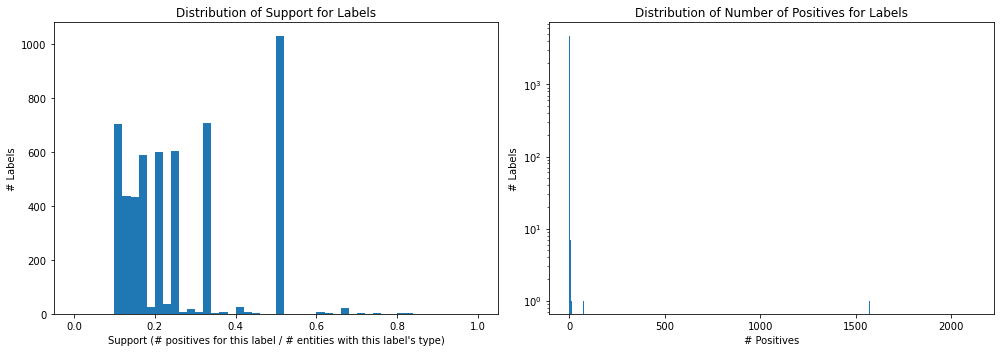

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q219557,'cult film'@en,P577,'publication date'@en,1975.0,,,3.0,30.0,0.100000
709,Q223740,'European Film Awards'@en,P571,'inception'@en,1989.0,,,5.0,41.0,0.121951
2154,Q655089,'International Indian Film Academy Awards'@en,P571,'inception'@en,2000.0,,,4.0,23.0,0.173913
4160,Q36784,'region of France'@en,P580,'start time'@en,1972.0,,,6.0,17.0,0.352941
5275,Q1137833,'core city of Japan'@en,P571,'inception'@en,1889.0,,,7.0,8.0,0.875000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
29,Q11315,'shopping center'@en,P1619,'date of official opening'@en,1972.0,,,1.0,10.0,0.100000
1138,Q1344,'opera'@en,P577,'publication date'@en,1850.0,,,8.0,59.0,0.135593
691,Q25110269,'live-action animated film'@en,P577,'publication date'@en,1927.0,,,19.0,168.0,0.113095
692,Q229390,'3D film'@en,P577,'publication date'@en,2015.0,,,82.0,722.0,0.113573
1141,Q20667187,'silent short film'@en,P577,'publication date'@en,1913.0,,,2115.0,15261.0,0.138589


In [16]:
plot_label_supports_and_positives(avl_year_file, avl_cols, log_scale_positives = True)

### AVL - quantity

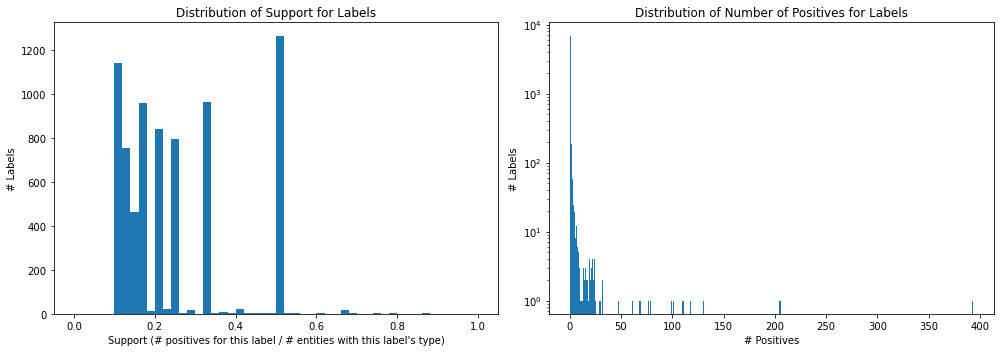

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q219557,'cult film'@en,P2047,'duration'@en,90.0,,Q7727,3.0,30.0,0.100000
1884,Q3624078,'sovereign state'@en,P3270,'compulsory education (minimum age)'@en,6.0,,Q577,30.0,232.0,0.129310
4160,Q54114,'boulevard'@en,P2049,'width'@en,42.0,,Q11573,4.0,18.0,0.222222
5995,Q20181813,'colonial power'@en,P2884,'mains voltage'@en,230.0,,Q25250,4.0,9.0,0.444444
7308,Q63791824,'countries bordering the Baltic Sea'@en,P3000,'marriageable age'@en,18.0,,Q24564698,8.0,9.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
3,Q1147395,'district of Turkey'@en,P2044,'elevation above sea level'@en,1150.0,,Q11573,1.0,10.0,0.100000
7275,Q2068728,'hit record'@en,P2635,'number of parts of this work'@en,20.0,,Q7302866,11.0,18.0,0.611111
461,Q6256,'country'@en,P2855,'VAT-rate'@en,18.0,,Q11229,21.0,208.0,0.100962
4992,Q3624078,'sovereign state'@en,P2884,'mains voltage'@en,220.0,,Q25250,68.0,232.0,0.293103
1130,Q17517379,'animated short film'@en,P2047,'duration'@en,7.0,,Q7727,393.0,3349.0,0.117348


In [17]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, log_scale_positives = True)

### AIL - year

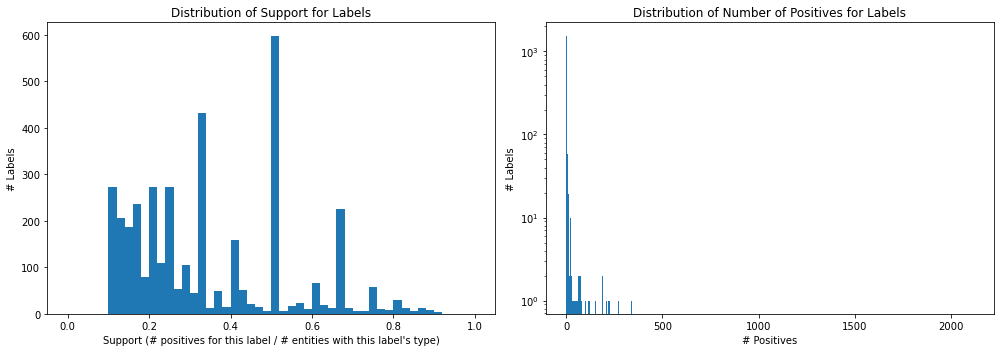

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q19020,'Academy Awards'@en,P571,'inception'@en,,1932,,,5.0,50.0,0.100000
877,Q559618,'fictional universe'@en,P571,'inception'@en,1983,,,,23.0,135.0,0.170370
1849,Q13218391,'charter city'@en,P571,'inception'@en,1819,1879,,,13.0,39.0,0.333333
3318,Q207628,'musical composition'@en,P577,'publication date'@en,1888.5,2000.5,,,72.0,119.0,0.605042
3758,Q641066,'girl group'@en,P571,'inception'@en,1958,,,,18.0,20.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
11,Q11315,'shopping center'@en,P571,'inception'@en,,1972.5,,,1.0,10.0,0.100000
1833,Q570116,'tourist attraction'@en,P1619,'date of official opening'@en,844,,,,32.0,102.0,0.313725
75,Q229390,'3D film'@en,P577,'publication date'@en,2013.5,2014.5,,,74.0,722.0,0.102493
3733,Q5741069,'rock band'@en,P571,'inception'@en,1963,2000,,,170.0,200.0,0.850000
475,Q20667187,'silent short film'@en,P577,'publication date'@en,1912.5,1913.5,,,2115.0,15261.0,0.138589


In [18]:
plot_label_supports_and_positives(ail_year_file, ail_cols, log_scale_positives = True)

### AIL - quantity

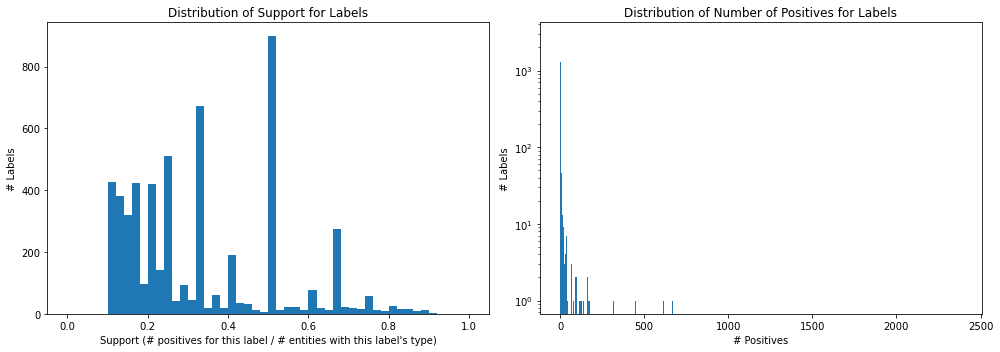

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q27686,'hotel'@en,P1101,'floors above ground'@en,,15,,,4.0,40.0,0.100000
1635,Q6256,'country'@en,P8476,'BTI Governance Index'@en,3.755,5.08,,,40.0,208.0,0.192308
3654,Q1110794,'daily newspaper'@en,P2896,'publication interval'@en,,,,Q573,5.0,13.0,0.384615
4990,Q1288568,'modern language'@en,P1098,'number of speakers'@en,,3.9e+07,,,205.0,331.0,0.619335
5514,Q6936225,'municipal corporation in India'@en,P2044,'elevation above sea level'@en,,1252.5,,Q11573,9.0,10.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
10,Q1147395,'district of Turkey'@en,P2044,'elevation above sea level'@en,1278.00,1587,,Q11573,1.0,10.0,0.100000
1057,Q6256,'country'@en,P3001,'retirement age'@en,61.00,,,Q24564698,31.0,208.0,0.149038
3651,Q6256,'country'@en,P2884,'mains voltage'@en,225.00,235,,Q25250,79.0,208.0,0.379808
5299,Q6256,'country'@en,P2855,'VAT-rate'@en,8.35,26,,Q11229,142.0,208.0,0.682692
2718,Q506240,'television film'@en,P2047,'duration'@en,41.00,127.5,,Q7727,2388.0,9351.0,0.255374


In [19]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, log_scale_positives = True)

### RELs

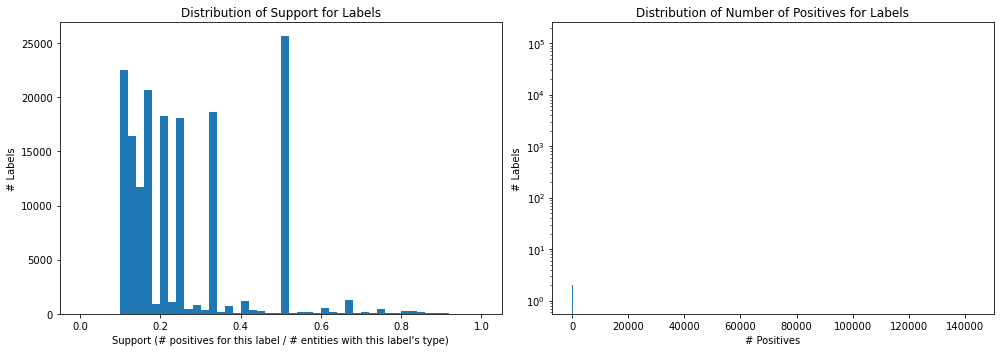

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
5509,Q1114461,'comics character'@en,P106,'occupation'@en,Q20085850,'fictional vigilante'@en,29.0,290.0,0.100000
51125,Q188784,'superhero'@en,P2563,'superhuman feature or ability'@en,Q47089006,'superhuman durability'@en,19.0,119.0,0.159664
130952,Q6256,'country'@en,P463,'member of'@en,Q47543,'Organisation of Islamic Cooperation'@en,55.0,208.0,0.264423
47269,Q1800833,'rockumentary'@en,P495,'country of origin'@en,Q30,'United States of America'@en,41.0,84.0,0.488095
14817,Q12538685,'roadshow'@en,P175,'performer'@en,Q1070606,'Momoiro Clover Z'@en,9.0,10.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
0,Q1001378,'cinematic technique'@en,P1056,'product or material produced'@en,Q16678561,'image film'@en,1.0,7.0,0.142857
5376,Q1107679,'animation studio'@en,P452,'industry'@en,Q2575347,'anime industry'@en,72.0,187.0,0.385027
68505,Q229390,'3D film'@en,P1552,'has quality'@en,Q45171911,'passes the Bechdel Test'@en,151.0,722.0,0.209141
58032,Q202866,'animated film'@en,P364,'original language of film or TV show'@en,Q1860,'English'@en,378.0,1025.0,0.368780
113077,Q5,'human'@en,P21,'sex or gender'@en,Q6581097,'male'@en,143134.0,204292.0,0.700634


In [20]:
plot_label_supports_and_positives(rel_file, rel_cols, log_scale_positives = True)

### RAVLs

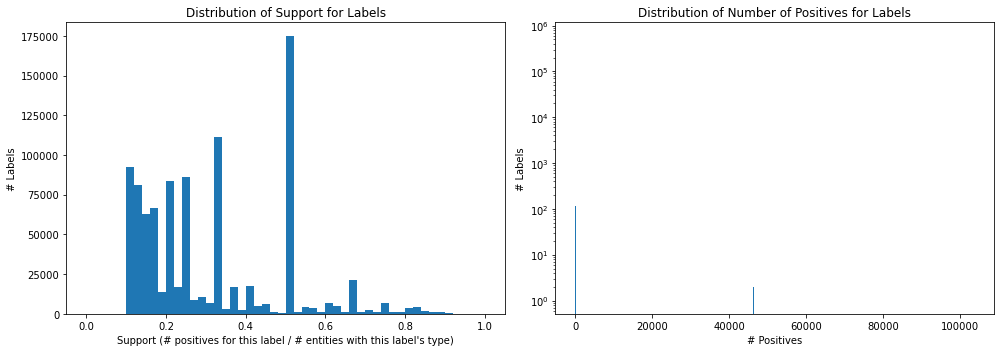

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
0,Q1549591,'big city'@en,P190,'twinned administrative body'@en,Q1549591,'big city'@en,P571,'inception'@en,1201.000,,,56.0,560.0,0.100000
226780,Q21745557,'Wikidata property to identify organizations'@en,P17,'country'@en,Q6256,'country'@en,P3000,'marriageable age'@en,18.000,,Q24564698,25.0,172.0,0.145349
416538,Q1107679,'animation studio'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P7295,'Gregorian calendar start date'@en,1582.000,,,44.0,187.0,0.235294
680621,Q6256,'country'@en,P530,'diplomatic relation'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.880,,,86.0,208.0,0.413462
938441,Q286069,'AACTA Awards'@en,P17,'country'@en,Q202686,'Commonwealth realm'@en,P1081,'Human Development Index'@en,0.939,,,27.0,30.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
1949,Q11266439,'Wikimedia template'@en,P1423,'template\\\\'s main topic'@en,Q11424,'film'@en,P2047,'duration'@en,101.000,,Q7727,1.0,10.0,0.100000
226782,Q29168811,'animated feature film'@en,P2363,'NMHH film rating'@en,Q23683425,'NMHH rating category'@en,P571,'inception'@en,2012.000,,,136.0,935.0,0.145455
401069,Q4830453,'business'@en,P17,'country'@en,Q1489259,'superpower'@en,P1081,'Human Development Index'@en,0.924,,,332.0,1508.0,0.220159
36414,Q20667187,'silent short film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P2884,'mains voltage'@en,230.000,,Q25250,1689.0,15261.0,0.110674
869144,Q5,'human'@en,P27,'country of citizenship'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18.000,,Q24564698,103510.0,204292.0,0.506677


In [21]:
plot_label_supports_and_positives(ravl_file, ravl_cols, log_scale_positives = True)

### RAILs

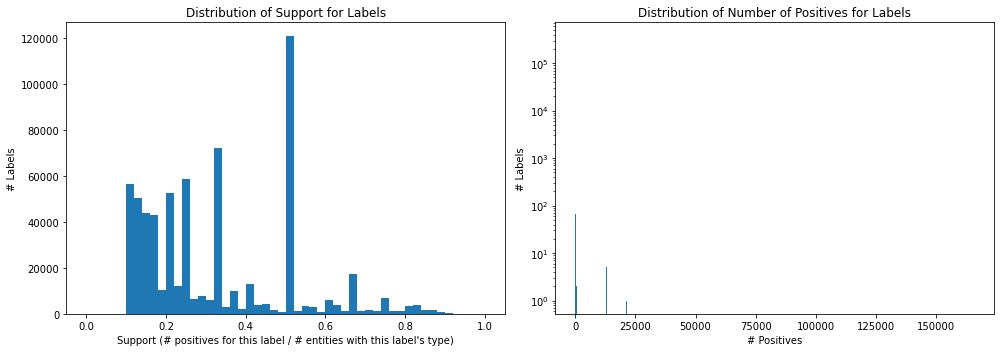

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q1762059,'film production company'@en,P17,'country'@en,Q6256,'country'@en,P571,'inception'@en,740,1072.5,,,192.0,1920.0,0.100000
189675,Q202866,'animated film'@en,P495,'country of origin'@en,Q6256,'country'@en,P4010,'GDP (PPP)'@en,,1.46577e+12,,Q550207,173.0,1025.0,0.168780
340517,Q22964274,'Wikidata property for identification in the f...,P17,'country'@en,Q6256,'country'@en,P2132,'nominal GDP per capita'@en,,24698.5,,Q4917,32.0,109.0,0.293578
578550,Q506240,'television film'@en,P495,'country of origin'@en,Q6256,'country'@en,P1125,'Gini coefficient'@en,39.45,55.4,,,4713.0,9351.0,0.504010
640631,Q5741069,'rock band'@en,P136,'genre'@en,Q188451,'music genre'@en,P571,'inception'@en,1927.5,,,,180.0,200.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
1553,Q11266439,'Wikimedia template'@en,P1423,'template\\\\'s main topic'@en,Q11424,'film'@en,P2047,'duration'@en,100.5,101.5,,Q7727,1.0,10.0,0.100000
151235,Q7725634,'literary work'@en,P495,'country of origin'@en,Q20181813,'colonial power'@en,P1081,'Human Development Index'@en,0.874,,,,325.0,2019.0,0.160971
16617,Q506240,'television film'@en,P495,'country of origin'@en,Q63791824,'countries bordering the Baltic Sea'@en,P2299,'PPP GDP per capita'@en,48874.2,,,Q550207,944.0,9351.0,0.100952
18223,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P1120,'number of deaths'@en,,,,,18185.0,176405.0,0.103087
632399,Q5,'human'@en,P27,'country of citizenship'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229,165571.0,204292.0,0.810462


In [22]:
plot_label_supports_and_positives(rail_file, rail_cols, log_scale_positives = True)

### All

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,9,11,12,13,14,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


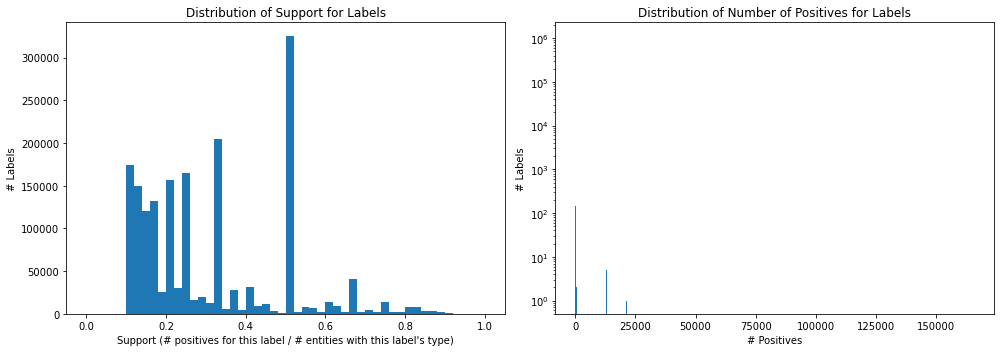

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
0,AVL,3.0,30.0,0.100000,Q219557,'cult film'@en,P2047,'duration'@en,90.0,,,,,,,,,,Q7727
1313277,RAIL,173.0,1025.0,0.168780,Q202866,'animated film'@en,P495,'country of origin'@en,,,,Q6256,'country'@en,P4010,'GDP (PPP)'@en,,1.46577e+12,,Q550207
708092,RAVL,52.0,175.0,0.297143,Q55452870,'Wikidata property related to encyclopedias'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P7295,'Gregorian calendar start date'@en,1582,,,
1702217,RAIL,65.0,128.0,0.507812,Q2001305,'television channel'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P3001,'retirement age'@en,61,,,Q24564698
27402,REL,9.0,10.0,0.900000,Q12538685,'roadshow'@en,P175,'performer'@en,Q1070606,'Momoiro Clover Z'@en,,,,,,,,,



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
3,AVL,1.0,10.0,0.100000,Q1147395,'district of Turkey'@en,P2044,'elevation above sea level'@en,1150.0,,,,,,,,,,Q11573
1390623,RAIL,353.0,1508.0,0.234085,Q4830453,'business'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2046,'area'@en,,1.42467e+06,,Q712226
1703573,RAIL,1028.0,1920.0,0.535417,Q1762059,'film production company'@en,P17,'country'@en,,,,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229
1176636,RAIL,20534.0,176405.0,0.116403,Q11424,'film'@en,P495,'country of origin'@en,,,,Q7270,'republic'@en,P3529,'median income'@en,25224.5,,,Q4917
1756001,RAIL,165571.0,204292.0,0.810462,Q5,'human'@en,P27,'country of citizenship'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229


In [23]:
plot_label_supports_and_positives(all_file, all_cols, log_scale_positives = True)

## Let's look at a subset of these labels since there are a lot of them here. 
Filter on type1 = whatever type we are interested in profiling

### Optional - create a file we can view in Excel
First let's create a smaller "all-labels" file just for type1=Q44 since this will be small enough that we can view the labels in Excel.

In [24]:
#df = pd.read_csv(all_file, delimiter = '\t')
#df = df.loc[df.loc[:,"type1"] == "Q44"]
#type1_is_q44_all_file = "{}/filtered_all_analysis_type1_is_q44.tsv".format(output_dir)
#df[all_cols].to_csv(path_or_buf = type1_is_q44_all_file, sep = '\t', index = False)

And again here are histograms of the label supports and positives...

In [25]:
type1 = "Q11424" # can change this to another type and then re-run the below cells.

### AVL - string

In [26]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, type1 = type1)

No string labels file found, skipping this step.


### AVL - year

In [27]:
plot_label_supports_and_positives(avl_year_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q11424


### AVL - quantity

In [28]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q11424


### AIL - year

In [29]:
plot_label_supports_and_positives(ail_year_file, ail_cols, type1 = type1)

There are no labels in the given file with type = Q11424


### AIL - quantity

In [30]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, type1 = type1)

There are no labels in the given file with type = Q11424


### RELs

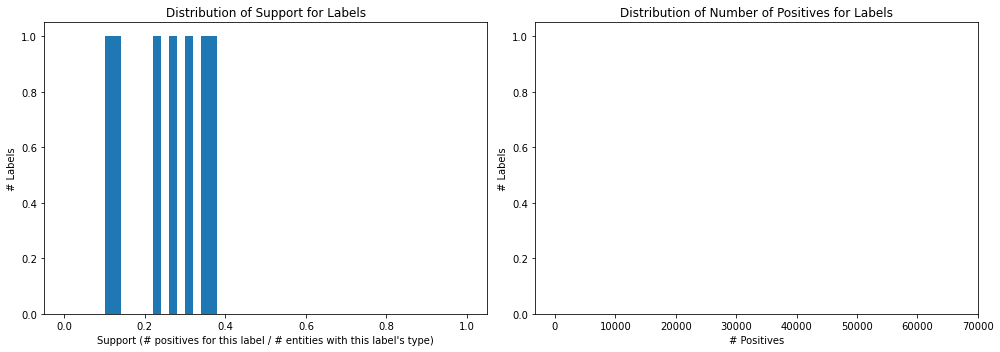

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
7098,Q11424,'film'@en,P136,'genre'@en,Q157443,'comedy film'@en,21020.0,176405.0,0.119158
7099,Q11424,'film'@en,P495,'country of origin'@en,Q668,'India'@en,23390.0,176405.0,0.132593
7101,Q11424,'film'@en,P136,'genre'@en,Q130232,'drama'@en,49208.0,176405.0,0.278949
7102,Q11424,'film'@en,P495,'country of origin'@en,Q30,'United States of America'@en,54749.0,176405.0,0.310360
7104,Q11424,'film'@en,P462,'color'@en,Q22006653,'color'@en,66684.0,176405.0,0.378016



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
7098,Q11424,'film'@en,P136,'genre'@en,Q157443,'comedy film'@en,21020.0,176405.0,0.119158
7099,Q11424,'film'@en,P495,'country of origin'@en,Q668,'India'@en,23390.0,176405.0,0.132593
7101,Q11424,'film'@en,P136,'genre'@en,Q130232,'drama'@en,49208.0,176405.0,0.278949
7102,Q11424,'film'@en,P495,'country of origin'@en,Q30,'United States of America'@en,54749.0,176405.0,0.310360
7104,Q11424,'film'@en,P462,'color'@en,Q22006653,'color'@en,66684.0,176405.0,0.378016


In [31]:
plot_label_supports_and_positives(rel_file, rel_cols, type1 = type1)

### RAVLs

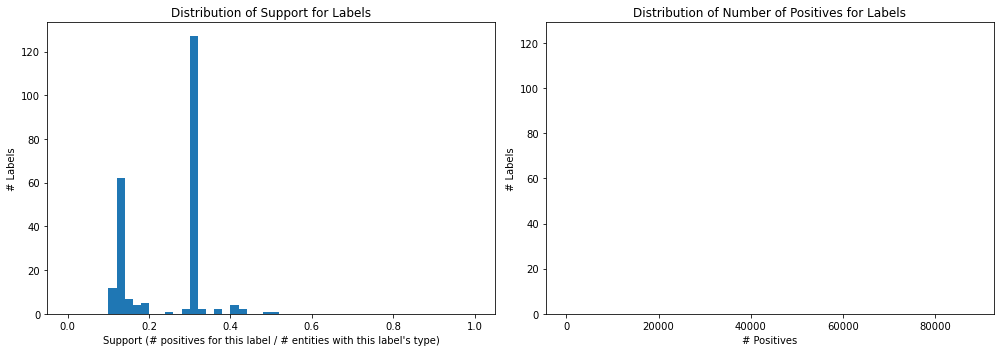

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
27492,Q11424,'film'@en,P495,'country of origin'@en,Q6256,'country'@en,P3270,'compulsory education (minimum age)'@en,5.0,,Q24564698,17664.0,176405.0,0.100133
168837,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P3271,'compulsory education (maximum age)'@en,16.0,,Q24564698,23363.0,176405.0,0.132440
234843,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P3271,'compulsory education (maximum age)'@en,14.0,,Q24564698,27174.0,176405.0,0.154043
528706,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,1.6,,Q11229,55101.0,176405.0,0.312355
869001,Q11424,'film'@en,P495,'country of origin'@en,Q6256,'country'@en,P2997,'age of majority'@en,18.0,,Q24564698,88236.0,176405.0,0.500190



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
27492,Q11424,'film'@en,P495,'country of origin'@en,Q6256,'country'@en,P3270,'compulsory education (minimum age)'@en,5.0,,Q24564698,17664.0,176405.0,0.100133
168837,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P3271,'compulsory education (maximum age)'@en,16.0,,Q24564698,23363.0,176405.0,0.132440
234843,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P3271,'compulsory education (maximum age)'@en,14.0,,Q24564698,27174.0,176405.0,0.154043
528706,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,1.6,,Q11229,55101.0,176405.0,0.312355
869001,Q11424,'film'@en,P495,'country of origin'@en,Q6256,'country'@en,P2997,'age of majority'@en,18.0,,Q24564698,88236.0,176405.0,0.500190


In [32]:
plot_label_supports_and_positives(ravl_file, ravl_cols, type1 = type1)

### RAILs

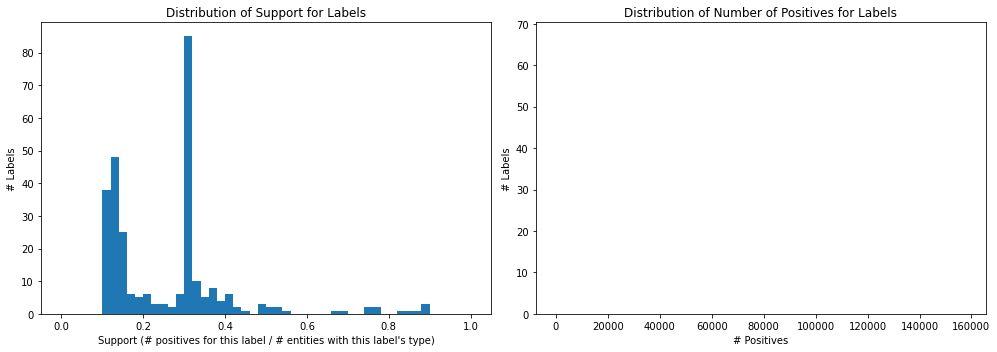

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
16790,Q11424,'film'@en,P495,'country of origin'@en,Q619610,'social state'@en,P1082,'population'@en,3.0393e+07,,,,17877.0,176405.0,0.101341
102504,Q11424,'film'@en,P495,'country of origin'@en,Q7270,'republic'@en,P3271,'compulsory education (maximum age)'@en,,15,,Q24564698,23493.0,176405.0,0.133176
203750,Q11424,'film'@en,P495,'country of origin'@en,Q7270,'republic'@en,P2855,'VAT-rate'@en,,14,,Q11229,34736.0,176405.0,0.196911
420258,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P2855,'VAT-rate'@en,8.35,26,,Q11229,61253.0,176405.0,0.347229
640579,Q11424,'film'@en,P495,'country of origin'@en,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229,157600.0,176405.0,0.893399



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
16790,Q11424,'film'@en,P495,'country of origin'@en,Q619610,'social state'@en,P1082,'population'@en,3.0393e+07,,,,17877.0,176405.0,0.101341
102504,Q11424,'film'@en,P495,'country of origin'@en,Q7270,'republic'@en,P3271,'compulsory education (maximum age)'@en,,15,,Q24564698,23493.0,176405.0,0.133176
203750,Q11424,'film'@en,P495,'country of origin'@en,Q7270,'republic'@en,P2855,'VAT-rate'@en,,14,,Q11229,34736.0,176405.0,0.196911
420258,Q11424,'film'@en,P495,'country of origin'@en,Q3624078,'sovereign state'@en,P2855,'VAT-rate'@en,8.35,26,,Q11229,61253.0,176405.0,0.347229
640579,Q11424,'film'@en,P495,'country of origin'@en,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229,157600.0,176405.0,0.893399


In [33]:
plot_label_supports_and_positives(rail_file, rail_cols, type1 = type1)

### All

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,9,11,12,13,14,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


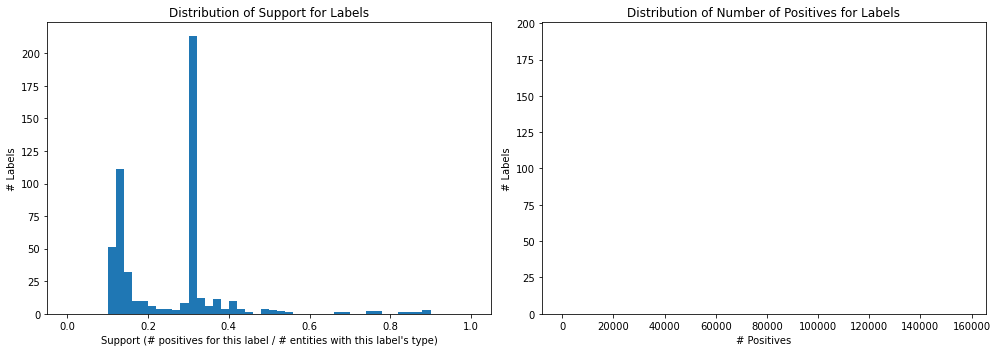

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
212233,RAVL,17664.0,176405.0,0.100133,Q11424,'film'@en,P495,'country of origin'@en,,,,Q6256,'country'@en,P3270,'compulsory education (minimum age)'@en,5,,,Q24564698
353705,RAVL,23493.0,176405.0,0.133176,Q11424,'film'@en,P495,'country of origin'@en,,,,Q7270,'republic'@en,P3271,'compulsory education (maximum age)'@en,14,,,Q24564698
1327352,RAIL,34736.0,176405.0,0.196911,Q11424,'film'@en,P495,'country of origin'@en,,,,Q7270,'republic'@en,P2855,'VAT-rate'@en,,14,,Q11229
1543860,RAIL,61253.0,176405.0,0.347229,Q11424,'film'@en,P495,'country of origin'@en,,,,Q3624078,'sovereign state'@en,P2855,'VAT-rate'@en,8.35,26,,Q11229
1764181,RAIL,157600.0,176405.0,0.893399,Q11424,'film'@en,P495,'country of origin'@en,,,,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
212233,RAVL,17664.0,176405.0,0.100133,Q11424,'film'@en,P495,'country of origin'@en,,,,Q6256,'country'@en,P3270,'compulsory education (minimum age)'@en,5,,,Q24564698
353705,RAVL,23493.0,176405.0,0.133176,Q11424,'film'@en,P495,'country of origin'@en,,,,Q7270,'republic'@en,P3271,'compulsory education (maximum age)'@en,14,,,Q24564698
1327352,RAIL,34736.0,176405.0,0.196911,Q11424,'film'@en,P495,'country of origin'@en,,,,Q7270,'republic'@en,P2855,'VAT-rate'@en,,14,,Q11229
1543860,RAIL,61253.0,176405.0,0.347229,Q11424,'film'@en,P495,'country of origin'@en,,,,Q3624078,'sovereign state'@en,P2855,'VAT-rate'@en,8.35,26,,Q11229
1764181,RAIL,157600.0,176405.0,0.893399,Q11424,'film'@en,P495,'country of origin'@en,,,,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-4.75,9.05,,Q11229


In [34]:
plot_label_supports_and_positives(all_file, all_cols, type1 = type1)